In [ ]:
#importing libraries

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, mean_absolute_error

from sklearn.decomposition import PCA 

from scipy.io import loadmat

from PIL import Image

import spectral
from spectral import principal_components,open_image
from matplotlib.pyplot import imshow
from spectral import create_training_classes,GaussianClassifier

import math

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from keras.utils import np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

from tqdm import tqdm
from numpy.random import seed
from time import time

In [ ]:
#loading datasets
X = loadmat("/content/Indian_pines_corrected.mat")["indian_pines_corrected"]
y = loadmat("/content/Indian_pines_gt.mat")["indian_pines_gt"]

In [ ]:
#shape of the dataset
print("pinesdata_shape", X.shape) 
print("groundtruth_shape", y.shape)

pinesdata_shape (145, 145, 200)
groundtruth_shape (145, 145)


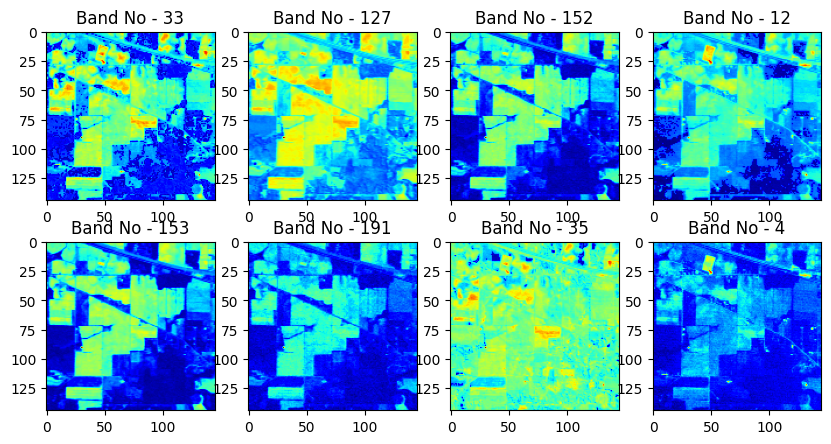

In [ ]:
#visualizing the bands
fig = plt.figure(figsize = (10, 5))

for i in range(1, 9):
    fig.add_subplot(2,4, i)
    band = np.random.randint(X.shape[2])
    plt.imshow(X[:,:,band], cmap = "jet")
    plt.title(f"Band No - {band}")

/usr/local/lib/python3.10/dist-packages/spectral/graphics/spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


ImageView object:
  Interpolation       :  <default>

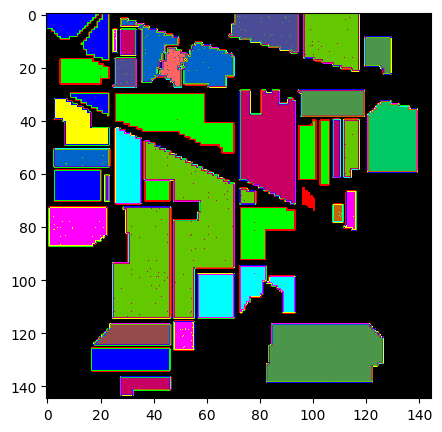

In [ ]:
#visualizing the ground truth image
spectral.imshow(classes = y.astype(int), figsize = (5,5))

spectral:INFO: Setting min samples to 200
INFO:spectral:Setting min samples to 200
spectral:WARNING: Omitting class   1 : only 46 samples present
spectral:WARNING: Omitting class   7 : only 28 samples present
spectral:WARNING: Omitting class   9 : only 20 samples present
spectral:WARNING: Omitting class  16 : only 93 samples present


Processing...  0.0%Processing...  8.3%Processing... 16.7%Processing... 25.0%Processing... 33.3%Processing... 41.7%Processing... 50.0%Processing... 58.3%Processing... 66.7%Processing... 75.0%Processing... 83.3%Processing... 91.7%Processing... 100.0%Processing...done   


ImageView object:
  Interpolation       :  <default>

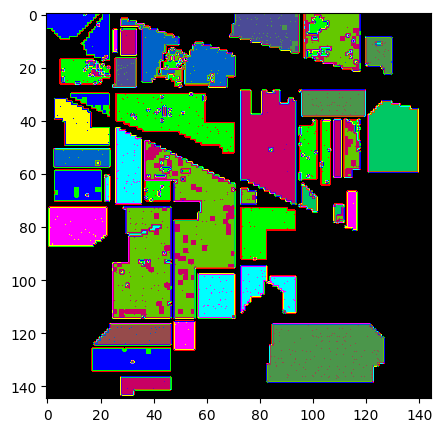

In [ ]:
#visualization of classification map of classes after applying a Gaussian classifier
classes = create_training_classes(X,y)
guc = GaussianClassifier(classes)
output = guc.classify_image(X)
results = output*(y!= 0)
spectral.imshow(classes = results.astype(int), figsize = (10,5))

ImageView object:
  Interpolation       :  <default>

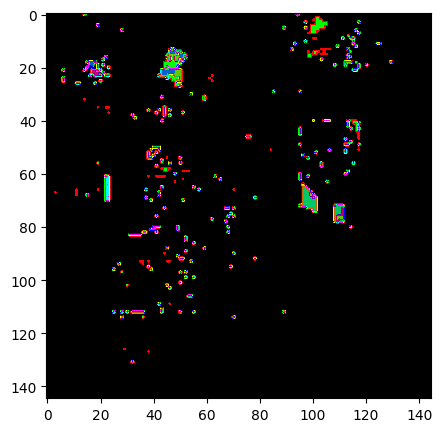

In [ ]:
#visualizing the error between the classification map and the ground truth image
error = results*(results!= y)
spectral.imshow(classes = error.astype(int), figsize = (10,5))

In [ ]:
#shapes of the classification map and the output of the Gaussian classifier
print(results.shape,output.shape)

(145, 145) (145, 145)


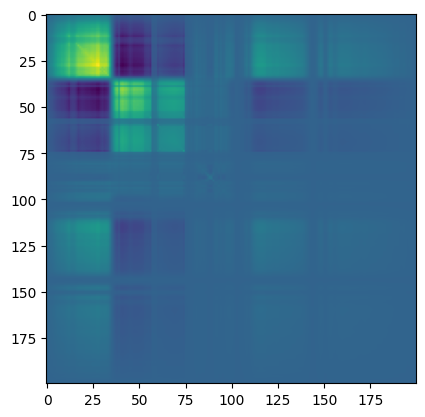

In [ ]:
#applying principal component analysis to the dataset and visualizing the covariance matrix of the principal components
pca = principal_components(X)

v = imshow(pca.cov)

In [ ]:
#reducing the dimensionality of the dataset by keeping 98.9% of the variance using PCA
pca_0989 = pca.reduce(fraction = 0.989)
len(pca_0989.eigenvalues)

24

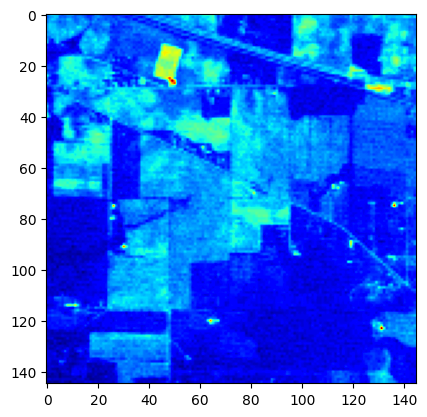

In [ ]:
#visualizing a band of the original dataset
plt.imshow(X[:,:,4], cmap = "jet")

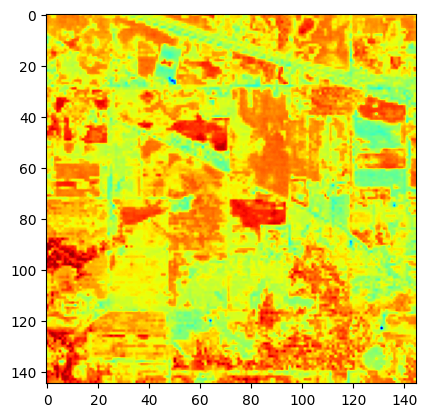

In [ ]:
#transforming the original dataset using the reduced number of principal components and visualizing one of the bands of the transformed dataset
img_pc = pca_0989.transform(X)
plt.imshow(img_pc[:,:,4], cmap = "jet")

In [ ]:
img_pc.shape

(145, 145, 24)

spectral:INFO: Setting min samples to 24
INFO:spectral:Setting min samples to 24
spectral:WARNING: Omitting class   9 : only 20 samples present


Processing...  0.0%Processing...  6.7%Processing... 13.3%Processing... 20.0%Processing... 26.7%Processing... 33.3%Processing... 40.0%Processing... 46.7%Processing... 53.3%Processing... 60.0%Processing... 66.7%Processing... 73.3%Processing... 80.0%Processing... 86.7%Processing... 93.3%Processing... 100.0%Processing...done   


ImageView object:
  Interpolation       :  <default>

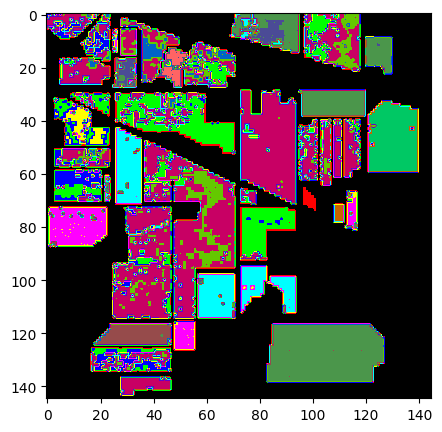

In [ ]:
#creating a training dataset and a Gaussian classifier using the transformed dataset and visualizing the classification map of classes after applying the classifier
classes = create_training_classes(img_pc,y)
guc = GaussianClassifier(classes)
output = guc.classify_image(img_pc)
results = output*(y!= 0)
spectral.imshow(classes = results.astype(int), figsize = (10,5))

ImageView object:
  Interpolation       :  <default>

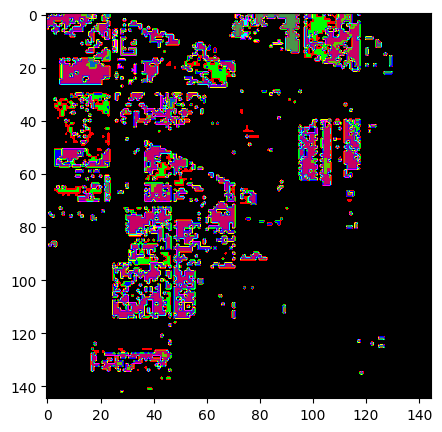

In [ ]:
#visualizing the error between the classification map and the ground truth image
error = results*(results!= y)
spectral.imshow(classes = error.astype(int), figsize = (10,5))

In [ ]:
#two utility functions are defined for creating windows of a specified size from the dataset and padding the dataset with zeros.

def padding_with_zeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [ ]:
#defining a function imagewindows() to split the image into patches of a specified size and create corresponding labels for each patch.

def imagewindows(X, y, windowSize = 5, removeZeroLabels = True):

    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padding_with_zeros(X, margin=margin)
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [ ]:
X_win, y = imagewindows(img_pc, y, windowSize = 25)
X_win.shape, y.shape

((10249, 25, 25, 24), (10249,))

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_win, y, test_size = 0.50, random_state = 42)

In [ ]:
X_train.shape, y_train.shape

((5124, 25, 25, 24), (5124,))

In [ ]:
#reshaping the training data to have a 5D shape
X_train = X_train.reshape(-1, 25, 25, 24, 1)
X_train.shape

(5124, 25, 25, 24, 1)

In [ ]:
y_train = np_utils.to_categorical(y_train)
y_train.shape

(5124, 16)

In [ ]:
model = tf.keras.models.Sequential([
        keras.layers.Conv3D(16, (3, 3, 3), input_shape = (25, 25, 24, 1)),
        keras.layers.Conv3D(32, (3, 3, 5)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation = "relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512, activation = "relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(16, activation = "softmax")
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 23, 23, 22, 16)    448       
                                                                 
 conv3d_1 (Conv3D)           (None, 21, 21, 18, 32)    23072     
                                                                 
 flatten (Flatten)           (None, 254016)            0         
                                                                 
 dense (Dense)               (None, 256)               65028352  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0

In [ ]:
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [ ]:
early_stop = EarlyStopping(monitor = "val_loss",
                           min_delta = 0,
                           patience = 10,
                           mode = "min",
                           verbose = 1,
                           restore_best_weights = True)

In [ ]:
checkpoint = ModelCheckpoint(filepath = "Indian_Pines_3DCNN.h5", 
                             monitor = "val_loss", 
                             mode = "min",
                             verbose = 1,
                             save_best_only = True)

In [ ]:
tensorboard = TensorBoard(log_dir = "SA_logs/{}".format(time()))

In [ ]:
history = model.fit(X_train, y_train, 
                    epochs = 100,
                    batch_size = 256,
                    callbacks = [early_stop, checkpoint, tensorboard])

Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 974.7471 - accuracy: 0.5943

21/21 [==============================] - 18s 165ms/step - loss: 974.7471 - accuracy: 0.5943
Epoch 2/100
20/21 [===========================>..] - ETA: 0s - loss: 245.3077 - accuracy: 0.8426

21/21 [==============================] - 3s 160ms/step - loss: 245.1162 - accuracy: 0.8427
Epoch 3/100
20/21 [===========================>..] - ETA: 0s - loss: 124.2052 - accuracy: 0.9115

21/21 [==============================] - 3s 160ms/step - loss: 124.1460 - accuracy: 0.9114
Epoch 4/100
20/21 [===========================>..] - ETA: 0s - loss: 150.8520 - accuracy: 0.9311

21/21 [==============================] - 3s 159ms/step - loss: 150.7342 - accuracy: 0.9311
Epoch 5/100
20/21 [===========================>..] - ETA: 0s - loss: 96.9365 - accuracy: 0.9523

21/21 [==============================] - 3s 159ms/step - loss: 96.8609 - accuracy: 0.9524
Epoch 6/100
20/21 [===========================>..] - ETA: 0s - loss: 66.7754 - accuracy: 0.9629

21/21 [==============================] - 3s 160ms/step - loss: 66.7233 - accuracy: 0.9629
Epoch 7/100
20/21 [===========================>..] - ETA: 0s - loss: 34.5640 - accuracy: 0.9727

21/21 [==============================] - 3s 160ms/step - loss: 34.5370 - accuracy: 0.9727
Epoch 8/100
20/21 [===========================>..] - ETA: 0s - loss: 32.1541 - accuracy: 0.9750

21/21 [==============================] - 3s 160ms/step - loss: 32.1290 - accuracy: 0.9750
Epoch 9/100
20/21 [===========================>..] - ETA: 0s - loss: 43.4683 - accuracy: 0.9770

21/21 [==============================] - 3s 159ms/step - loss: 43.4343 - accuracy: 0.9770
Epoch 10/100
20/21 [===========================>..] - ETA: 0s - loss: 33.0493 - accuracy: 0.9781

21/21 [==============================] - 3s 163ms/step - loss: 33.0235 - accuracy: 0.9781
Epoch 11/100
20/21 [===========================>..] - ETA: 0s - loss: 26.8213 - accuracy: 0.9789

21/21 [==============================] - 3s 160ms/step - loss: 26.8004 - accuracy: 0.9789
Epoch 12/100
20/21 [===========================>..] - ETA: 0s - loss: 18.5920 - accuracy: 0.9869

21/21 [==============================] - 3s 161ms/step - loss: 18.5775 - accuracy: 0.9869
Epoch 13/100
20/21 [===========================>..] - ETA: 0s - loss: 17.6158 - accuracy: 0.9881

21/21 [==============================] - 3s 162ms/step - loss: 17.6020 - accuracy: 0.9881
Epoch 14/100
20/21 [===========================>..] - ETA: 0s - loss: 16.8055 - accuracy: 0.9865

21/21 [==============================] - 3s 163ms/step - loss: 16.7923 - accuracy: 0.9865
Epoch 15/100
20/21 [===========================>..] - ETA: 0s - loss: 17.1441 - accuracy: 0.9869

21/21 [==============================] - 3s 161ms/step - loss: 17.1307 - accuracy: 0.9869
Epoch 16/100
20/21 [===========================>..] - ETA: 0s - loss: 12.4755 - accuracy: 0.9900

21/21 [==============================] - 3s 166ms/step - loss: 12.4657 - accuracy: 0.9900
Epoch 17/100
20/21 [===========================>..] - ETA: 0s - loss: 14.7844 - accuracy: 0.9906

21/21 [==============================] - 3s 166ms/step - loss: 14.7729 - accuracy: 0.9906
Epoch 18/100
20/21 [===========================>..] - ETA: 0s - loss: 11.7478 - accuracy: 0.9910

21/21 [==============================] - 3s 163ms/step - loss: 11.7386 - accuracy: 0.9910
Epoch 19/100
20/21 [===========================>..] - ETA: 0s - loss: 9.9993 - accuracy: 0.9922

21/21 [==============================] - 3s 163ms/step - loss: 9.9915 - accuracy: 0.9922
Epoch 20/100
20/21 [===========================>..] - ETA: 0s - loss: 7.1409 - accuracy: 0.9928

21/21 [==============================] - 3s 165ms/step - loss: 7.1353 - accuracy: 0.9928
Epoch 21/100
20/21 [===========================>..] - ETA: 0s - loss: 14.7682 - accuracy: 0.9908

21/21 [==============================] - 4s 166ms/step - loss: 14.7567 - accuracy: 0.9908
Epoch 22/100
20/21 [===========================>..] - ETA: 0s - loss: 10.5298 - accuracy: 0.9939

21/21 [==============================] - 3s 164ms/step - loss: 10.5216 - accuracy: 0.9940
Epoch 23/100
20/21 [===========================>..] - ETA: 0s - loss: 11.2589 - accuracy: 0.9908

21/21 [==============================] - 3s 165ms/step - loss: 11.2501 - accuracy: 0.9908
Epoch 24/100
20/21 [===========================>..] - ETA: 0s - loss: 11.2199 - accuracy: 0.9916

21/21 [==============================] - 4s 167ms/step - loss: 11.2111 - accuracy: 0.9916
Epoch 25/100
20/21 [===========================>..] - ETA: 0s - loss: 16.3164 - accuracy: 0.9910

21/21 [==============================] - 4s 166ms/step - loss: 16.3036 - accuracy: 0.9910
Epoch 26/100
20/21 [===========================>..] - ETA: 0s - loss: 10.2513 - accuracy: 0.9914

21/21 [==============================] - 4s 167ms/step - loss: 10.2433 - accuracy: 0.9914
Epoch 27/100
20/21 [===========================>..] - ETA: 0s - loss: 10.1405 - accuracy: 0.9916

21/21 [==============================] - 4s 166ms/step - loss: 10.1326 - accuracy: 0.9916
Epoch 28/100
20/21 [===========================>..] - ETA: 0s - loss: 8.1391 - accuracy: 0.9928

21/21 [==============================] - 4s 169ms/step - loss: 8.1327 - accuracy: 0.9928
Epoch 29/100
20/21 [===========================>..] - ETA: 0s - loss: 9.8231 - accuracy: 0.9928 

21/21 [==============================] - 4s 167ms/step - loss: 9.8154 - accuracy: 0.9928
Epoch 30/100
20/21 [===========================>..] - ETA: 0s - loss: 7.5147 - accuracy: 0.9932

21/21 [==============================] - 4s 170ms/step - loss: 7.5088 - accuracy: 0.9932
Epoch 31/100
20/21 [===========================>..] - ETA: 0s - loss: 9.6988 - accuracy: 0.9936 

21/21 [==============================] - 4s 170ms/step - loss: 9.6912 - accuracy: 0.9936
Epoch 32/100
20/21 [===========================>..] - ETA: 0s - loss: 7.5803 - accuracy: 0.9943

21/21 [==============================] - 4s 168ms/step - loss: 7.5744 - accuracy: 0.9943
Epoch 33/100
20/21 [===========================>..] - ETA: 0s - loss: 9.9882 - accuracy: 0.9941

21/21 [==============================] - 4s 168ms/step - loss: 9.9804 - accuracy: 0.9941
Epoch 34/100
20/21 [===========================>..] - ETA: 0s - loss: 7.9747 - accuracy: 0.9951

21/21 [==============================] - 4s 168ms/step - loss: 7.9685 - accuracy: 0.9951
Epoch 35/100
20/21 [===========================>..] - ETA: 0s - loss: 5.9516 - accuracy: 0.9930

21/21 [==============================] - 4s 170ms/step - loss: 5.9469 - accuracy: 0.9930
Epoch 36/100
20/21 [===========================>..] - ETA: 0s - loss: 9.6868 - accuracy: 0.9947 

21/21 [==============================] - 4s 167ms/step - loss: 9.6792 - accuracy: 0.9947
Epoch 37/100
20/21 [===========================>..] - ETA: 0s - loss: 11.6096 - accuracy: 0.9928

21/21 [==============================] - 4s 167ms/step - loss: 11.6005 - accuracy: 0.9928
Epoch 38/100
20/21 [===========================>..] - ETA: 0s - loss: 7.1493 - accuracy: 0.9943

21/21 [==============================] - 4s 167ms/step - loss: 7.1437 - accuracy: 0.9943
Epoch 39/100
20/21 [===========================>..] - ETA: 0s - loss: 6.3534 - accuracy: 0.9955

21/21 [==============================] - 4s 168ms/step - loss: 6.3485 - accuracy: 0.9955
Epoch 40/100
20/21 [===========================>..] - ETA: 0s - loss: 6.6112 - accuracy: 0.9939

21/21 [==============================] - 4s 175ms/step - loss: 6.6060 - accuracy: 0.9940
Epoch 41/100
20/21 [===========================>..] - ETA: 0s - loss: 6.5425 - accuracy: 0.9955

21/21 [==============================] - 4s 172ms/step - loss: 6.5374 - accuracy: 0.9955
Epoch 42/100
20/21 [===========================>..] - ETA: 0s - loss: 13.3874 - accuracy: 0.9916

21/21 [==============================] - 4s 168ms/step - loss: 13.3770 - accuracy: 0.9916
Epoch 43/100
20/21 [===========================>..] - ETA: 0s - loss: 5.9346 - accuracy: 0.9939

21/21 [==============================] - 3s 166ms/step - loss: 5.9300 - accuracy: 0.9940
Epoch 44/100
20/21 [===========================>..] - ETA: 0s - loss: 9.2640 - accuracy: 0.9945

21/21 [==============================] - 3s 166ms/step - loss: 9.2568 - accuracy: 0.9945
Epoch 45/100
20/21 [===========================>..] - ETA: 0s - loss: 5.8874 - accuracy: 0.9949

21/21 [==============================] - 4s 169ms/step - loss: 5.8828 - accuracy: 0.9949
Epoch 46/100
20/21 [===========================>..] - ETA: 0s - loss: 8.5544 - accuracy: 0.9928

21/21 [==============================] - 4s 167ms/step - loss: 8.5478 - accuracy: 0.9928
Epoch 47/100
20/21 [===========================>..] - ETA: 0s - loss: 11.0897 - accuracy: 0.9916

21/21 [==============================] - 4s 166ms/step - loss: 11.0811 - accuracy: 0.9916
Epoch 48/100
20/21 [===========================>..] - ETA: 0s - loss: 8.2891 - accuracy: 0.9934

21/21 [==============================] - 4s 166ms/step - loss: 8.2826 - accuracy: 0.9934
Epoch 49/100
20/21 [===========================>..] - ETA: 0s - loss: 7.9988 - accuracy: 0.9953

21/21 [==============================] - 4s 168ms/step - loss: 7.9925 - accuracy: 0.9953
Epoch 50/100
20/21 [===========================>..] - ETA: 0s - loss: 4.1668 - accuracy: 0.9953

21/21 [==============================] - 3s 166ms/step - loss: 4.1636 - accuracy: 0.9953
Epoch 51/100
20/21 [===========================>..] - ETA: 0s - loss: 4.9334 - accuracy: 0.9969

21/21 [==============================] - 3s 166ms/step - loss: 4.9296 - accuracy: 0.9969
Epoch 52/100
20/21 [===========================>..] - ETA: 0s - loss: 6.2197 - accuracy: 0.9957

21/21 [==============================] - 4s 168ms/step - loss: 6.2149 - accuracy: 0.9957
Epoch 53/100
20/21 [===========================>..] - ETA: 0s - loss: 6.6343 - accuracy: 0.9951

21/21 [==============================] - 4s 167ms/step - loss: 6.6292 - accuracy: 0.9951
Epoch 54/100
20/21 [===========================>..] - ETA: 0s - loss: 7.3237 - accuracy: 0.9967

21/21 [==============================] - 4s 167ms/step - loss: 7.3180 - accuracy: 0.9967
Epoch 55/100
20/21 [===========================>..] - ETA: 0s - loss: 7.9202 - accuracy: 0.9953

21/21 [==============================] - 3s 166ms/step - loss: 7.9141 - accuracy: 0.9953
Epoch 56/100
20/21 [===========================>..] - ETA: 0s - loss: 6.0388 - accuracy: 0.9955

21/21 [==============================] - 4s 169ms/step - loss: 6.0341 - accuracy: 0.9955
Epoch 57/100
20/21 [===========================>..] - ETA: 0s - loss: 7.9789 - accuracy: 0.9955

21/21 [==============================] - 4s 167ms/step - loss: 7.9726 - accuracy: 0.9955
Epoch 58/100
20/21 [===========================>..] - ETA: 0s - loss: 5.7744 - accuracy: 0.9957

21/21 [==============================] - 4s 167ms/step - loss: 5.7698 - accuracy: 0.9957
Epoch 59/100
20/21 [===========================>..] - ETA: 0s - loss: 8.1815 - accuracy: 0.9947

21/21 [==============================] - 4s 168ms/step - loss: 8.1751 - accuracy: 0.9947
Epoch 60/100
20/21 [===========================>..] - ETA: 0s - loss: 12.4872 - accuracy: 0.9957

21/21 [==============================] - 4s 168ms/step - loss: 12.4774 - accuracy: 0.9957
Epoch 61/100
20/21 [===========================>..] - ETA: 0s - loss: 6.5618 - accuracy: 0.9955

21/21 [==============================] - 4s 167ms/step - loss: 6.5567 - accuracy: 0.9955
Epoch 62/100
20/21 [===========================>..] - ETA: 0s - loss: 4.9435 - accuracy: 0.9945

21/21 [==============================] - 3s 166ms/step - loss: 4.9397 - accuracy: 0.9945
Epoch 63/100
20/21 [===========================>..] - ETA: 0s - loss: 5.4741 - accuracy: 0.9943

21/21 [==============================] - 4s 170ms/step - loss: 5.4698 - accuracy: 0.9943
Epoch 64/100
20/21 [===========================>..] - ETA: 0s - loss: 7.3595 - accuracy: 0.9961

21/21 [==============================] - 4s 167ms/step - loss: 7.3537 - accuracy: 0.9961
Epoch 65/100
20/21 [===========================>..] - ETA: 0s - loss: 7.0815 - accuracy: 0.9963

21/21 [==============================] - 3s 166ms/step - loss: 7.0760 - accuracy: 0.9963
Epoch 66/100
20/21 [===========================>..] - ETA: 0s - loss: 8.8042 - accuracy: 0.9963

21/21 [==============================] - 4s 168ms/step - loss: 8.7973 - accuracy: 0.9963
Epoch 67/100
20/21 [===========================>..] - ETA: 0s - loss: 8.4919 - accuracy: 0.9945

21/21 [==============================] - 4s 168ms/step - loss: 8.4853 - accuracy: 0.9945
Epoch 68/100
20/21 [===========================>..] - ETA: 0s - loss: 10.5382 - accuracy: 0.9949

21/21 [==============================] - 4s 173ms/step - loss: 10.5300 - accuracy: 0.9949
Epoch 69/100
20/21 [===========================>..] - ETA: 0s - loss: 12.1571 - accuracy: 0.9924

21/21 [==============================] - 4s 179ms/step - loss: 12.1476 - accuracy: 0.9924
Epoch 70/100
20/21 [===========================>..] - ETA: 0s - loss: 8.4054 - accuracy: 0.9932

21/21 [==============================] - 4s 168ms/step - loss: 8.3989 - accuracy: 0.9932
Epoch 71/100
20/21 [===========================>..] - ETA: 0s - loss: 8.6852 - accuracy: 0.9949

21/21 [==============================] - 4s 167ms/step - loss: 8.6784 - accuracy: 0.9949
Epoch 72/100
20/21 [===========================>..] - ETA: 0s - loss: 4.2933 - accuracy: 0.9961

21/21 [==============================] - 3s 166ms/step - loss: 4.2900 - accuracy: 0.9961
Epoch 73/100
20/21 [===========================>..] - ETA: 0s - loss: 6.0650 - accuracy: 0.9963

21/21 [==============================] - 4s 167ms/step - loss: 6.0602 - accuracy: 0.9963
Epoch 74/100
20/21 [===========================>..] - ETA: 0s - loss: 12.2393 - accuracy: 0.9939

21/21 [==============================] - 4s 168ms/step - loss: 12.2297 - accuracy: 0.9940
Epoch 75/100
20/21 [===========================>..] - ETA: 0s - loss: 6.5926 - accuracy: 0.9945

21/21 [==============================] - 4s 167ms/step - loss: 6.5875 - accuracy: 0.9945
Epoch 76/100
20/21 [===========================>..] - ETA: 0s - loss: 7.5722 - accuracy: 0.9957

21/21 [==============================] - 3s 166ms/step - loss: 7.5663 - accuracy: 0.9957
Epoch 77/100
20/21 [===========================>..] - ETA: 0s - loss: 9.2981 - accuracy: 0.9943

21/21 [==============================] - 4s 168ms/step - loss: 9.2908 - accuracy: 0.9943
Epoch 78/100
20/21 [===========================>..] - ETA: 0s - loss: 10.2277 - accuracy: 0.9941

21/21 [==============================] - 4s 167ms/step - loss: 10.2197 - accuracy: 0.9941
Epoch 79/100
20/21 [===========================>..] - ETA: 0s - loss: 12.5315 - accuracy: 0.9945

21/21 [==============================] - 3s 166ms/step - loss: 12.5217 - accuracy: 0.9945
Epoch 80/100
20/21 [===========================>..] - ETA: 0s - loss: 12.1210 - accuracy: 0.9945

21/21 [==============================] - 4s 168ms/step - loss: 12.2211 - accuracy: 0.9943
Epoch 81/100
20/21 [===========================>..] - ETA: 0s - loss: 156.6999 - accuracy: 0.9754

21/21 [==============================] - 4s 170ms/step - loss: 156.5776 - accuracy: 0.9754
Epoch 82/100
20/21 [===========================>..] - ETA: 0s - loss: 320.1880 - accuracy: 0.9615

21/21 [==============================] - 4s 168ms/step - loss: 320.4646 - accuracy: 0.9614
Epoch 83/100
20/21 [===========================>..] - ETA: 0s - loss: 2128.5649 - accuracy: 0.9223

21/21 [==============================] - 4s 168ms/step - loss: 2132.7424 - accuracy: 0.9221
Epoch 84/100
20/21 [===========================>..] - ETA: 0s - loss: 1693.2410 - accuracy: 0.9240

21/21 [==============================] - 4s 171ms/step - loss: 1691.9192 - accuracy: 0.9241
Epoch 85/100
20/21 [===========================>..] - ETA: 0s - loss: 595.1295 - accuracy: 0.9580

21/21 [==============================] - 4s 168ms/step - loss: 594.6650 - accuracy: 0.9580
Epoch 86/100
20/21 [===========================>..] - ETA: 0s - loss: 251.4850 - accuracy: 0.9812

21/21 [==============================] - 4s 167ms/step - loss: 251.2887 - accuracy: 0.9813
Epoch 87/100
20/21 [===========================>..] - ETA: 0s - loss: 254.6728 - accuracy: 0.9818

21/21 [==============================] - 4s 168ms/step - loss: 270.3801 - accuracy: 0.9817
Epoch 88/100
20/21 [===========================>..] - ETA: 0s - loss: 1440.4340 - accuracy: 0.9520

21/21 [==============================] - 4s 169ms/step - loss: 1439.3096 - accuracy: 0.9520
Epoch 89/100
20/21 [===========================>..] - ETA: 0s - loss: 347.9276 - accuracy: 0.9795

21/21 [==============================] - 4s 167ms/step - loss: 347.6559 - accuracy: 0.9795
Epoch 90/100
20/21 [===========================>..] - ETA: 0s - loss: 218.3525 - accuracy: 0.9859

21/21 [==============================] - 4s 167ms/step - loss: 218.1820 - accuracy: 0.9859
Epoch 91/100
20/21 [===========================>..] - ETA: 0s - loss: 262.6928 - accuracy: 0.9887

21/21 [==============================] - 4s 170ms/step - loss: 262.4877 - accuracy: 0.9887
Epoch 92/100
20/21 [===========================>..] - ETA: 0s - loss: 115.7505 - accuracy: 0.9910

21/21 [==============================] - 4s 167ms/step - loss: 115.6602 - accuracy: 0.9910
Epoch 93/100
20/21 [===========================>..] - ETA: 0s - loss: 99.5199 - accuracy: 0.9912

21/21 [==============================] - 4s 167ms/step - loss: 99.4422 - accuracy: 0.9912
Epoch 94/100
20/21 [===========================>..] - ETA: 0s - loss: 77.2512 - accuracy: 0.9934

21/21 [==============================] - 4s 167ms/step - loss: 77.1909 - accuracy: 0.9934
Epoch 95/100
20/21 [===========================>..] - ETA: 0s - loss: 94.6118 - accuracy: 0.9922

21/21 [==============================] - 4s 168ms/step - loss: 94.5379 - accuracy: 0.9922
Epoch 96/100
20/21 [===========================>..] - ETA: 0s - loss: 64.1758 - accuracy: 0.9943

21/21 [==============================] - 3s 166ms/step - loss: 64.1257 - accuracy: 0.9943
Epoch 97/100
20/21 [===========================>..] - ETA: 0s - loss: 69.9406 - accuracy: 0.9939

21/21 [==============================] - 3s 166ms/step - loss: 69.8860 - accuracy: 0.9940
Epoch 98/100
20/21 [===========================>..] - ETA: 0s - loss: 80.4790 - accuracy: 0.9941

21/21 [==============================] - 4s 171ms/step - loss: 80.4161 - accuracy: 0.9941
Epoch 99/100
20/21 [===========================>..] - ETA: 0s - loss: 74.5055 - accuracy: 0.9953

21/21 [==============================] - 4s 166ms/step - loss: 74.4473 - accuracy: 0.9953
Epoch 100/100
20/21 [===========================>..] - ETA: 0s - loss: 36.2562 - accuracy: 0.9963

21/21 [==============================] - 3s 166ms/step - loss: 36.2278 - accuracy: 0.9963


In [ ]:
y_pred = model.predict(X_test)

161/161 [==============================] - 2s 9ms/step


Text(0.5, 1.0, 'Training Accuracy')

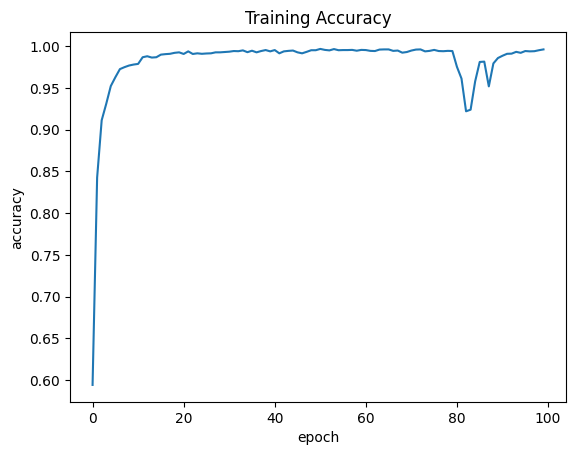

In [ ]:
plt.plot(history.history["accuracy"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Training Accuracy")

Text(0.5, 1.0, 'Training loss')

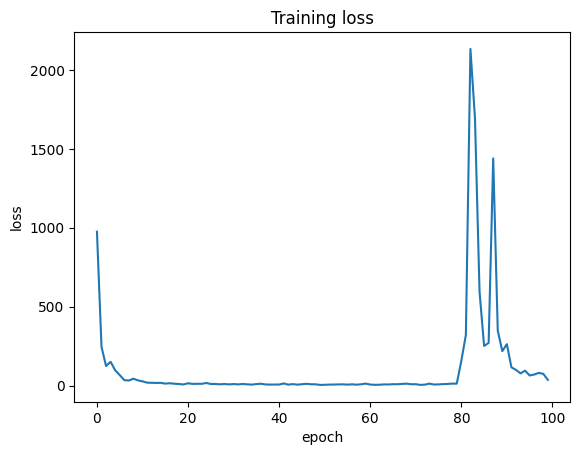

In [ ]:
plt.plot(history.history["loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Training loss")

In [ ]:
model.save("/content/indianapines_3DCNNmodel.h5")

In [ ]:
X_test_reshaped = X_test.reshape(-1, 25, 25, 24, 1)
X_test_reshaped.shape

(5125, 25, 25, 24, 1)

In [ ]:
y_test_reshaped = np_utils.to_categorical(y_test )
y_test_reshaped.shape

(5125, 16)

In [ ]:
y_prediction_test = model.predict(X_test_reshaped)
y_pred_test = np.argmax(y_prediction_test, axis = 1)
y_test_uncategorical = np.argmax(y_test_reshaped, axis = 1)

161/161 [==============================] - 2s 10ms/step


In [ ]:
# Classification Report
report = classification_report(y_test_uncategorical, y_pred_test, target_names=["Alfalfa", "Corn-notill", "Corn-mintill", "Corn", "Grass-pasture", "Grass-trees", "Grass-pasture-mowed", "Hay-windrowed", "Oats", "Soybean-notill", "Soybean-mintill", "Soybean-clean", "Wheat", "Woods", "Buildings-Grass-Trees-Drives", "Stone-Steel-Towers"])

print(report)

                              precision    recall  f1-score   support

                     Alfalfa       1.00      1.00      1.00        29
                 Corn-notill       1.00      1.00      1.00       700
                Corn-mintill       1.00      1.00      1.00       415
                        Corn       0.99      1.00      1.00       108
               Grass-pasture       1.00      1.00      1.00       240
                 Grass-trees       0.99      1.00      1.00       367
         Grass-pasture-mowed       1.00      1.00      1.00        15
               Hay-windrowed       1.00      1.00      1.00       238
                        Oats       1.00      1.00      1.00         8
              Soybean-notill       1.00      1.00      1.00       494
             Soybean-mintill       1.00      1.00      1.00      1200
               Soybean-clean       1.00      0.99      1.00       308
                       Wheat       1.00      1.00      1.00        97
                   

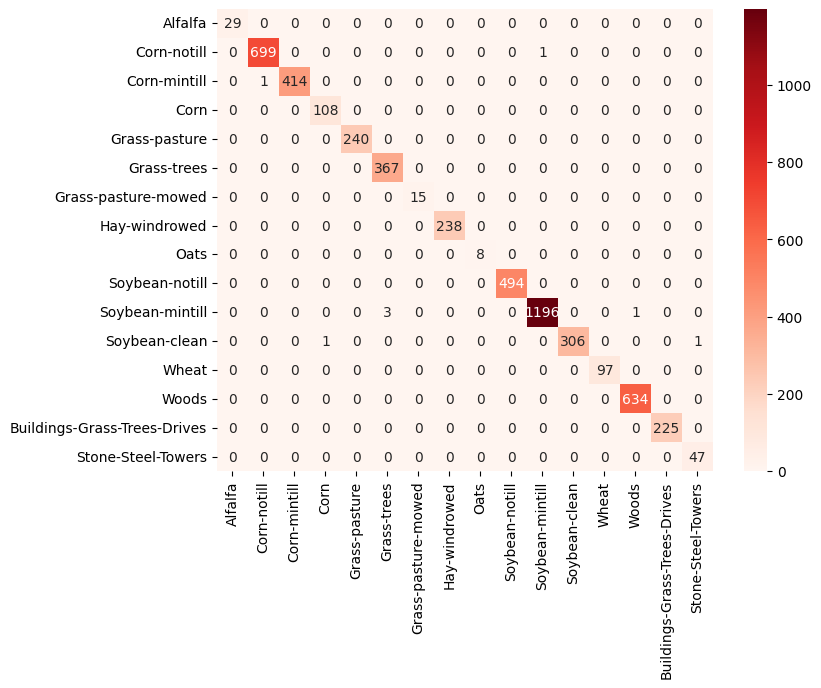

In [ ]:
plt.figure(figsize = (8,6))

#confusion matrix
c_matrix = confusion_matrix(y_test_uncategorical, y_pred_test)

#heatmap of the confusion matrix
sns.heatmap(c_matrix, annot = True, annot_kws = {"size": 10}, fmt= "d", cmap = "Reds", 
            xticklabels=["Alfalfa", "Corn-notill", "Corn-mintill", "Corn", "Grass-pasture", "Grass-trees", "Grass-pasture-mowed", "Hay-windrowed", "Oats", "Soybean-notill", "Soybean-mintill", "Soybean-clean", "Wheat", "Woods", "Buildings-Grass-Trees-Drives", "Stone-Steel-Towers"], 
            yticklabels=["Alfalfa", "Corn-notill", "Corn-mintill", "Corn", "Grass-pasture", "Grass-trees", "Grass-pasture-mowed", "Hay-windrowed", "Oats", "Soybean-notill", "Soybean-mintill", "Soybean-clean", "Wheat", "Woods", "Buildings-Grass-Trees-Drives", "Stone-Steel-Towers"])

plt.show()

In [ ]:
MSE = np.square(np.subtract(y_test_uncategorical, y_pred_test)).mean() 
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n", RMSE)

Root Mean Square Error:
 0.21908902300206645


In [ ]:
print("Mean Absolute Error (MAE)", mean_absolute_error(y_test_uncategorical, y_pred_test))

Mean Absolute Error (MAE) 0.007804878048780488
